# Working with Data post 2017Q2 and Removing 2018Q3

In this notebook we transfer some of the stuff across from the Analysis Notebook.
Firstly I then create a function to remove 2018Q3.

-----------------

Below is firstly the import of packages and pre-built function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels as sm

fullData_31 = pd.read_csv("31DayData.csv")
myData_31 = fullData_31[['Quarter', 'HB', 'HBT', 'CancerType','NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days']]

def ReigonTypeQuarterSelector(data, reigonCode, cancerType, quarterSplit):
    typeData = data[data['CancerType'] == cancerType]
    reigonalData = typeData[typeData['HB'] == reigonCode]
    
    aggregation_functions = {'Quarter':'first', 'HB': 'first', 'CancerType': 'first', 'NumberOfEligibleReferrals31DayStandard': 'sum', 'NumberOfEligibleReferralsTreatedWithin31Days': 'sum'}
    reigonalData = reigonalData.groupby(reigonalData['Quarter'], as_index=False).aggregate(aggregation_functions)
        
    Qs = reigonalData.iloc[:,[0]]
    QsReset = Qs.reset_index()
    Index = min(QsReset.index[QsReset['Quarter'] == quarterSplit].tolist())
    
    PreQ = reigonalData.iloc[:Index,:]
    PostQ = reigonalData.iloc[Index:,:]
    
    x = PreQ["Quarter"]
    y = PreQ["NumberOfEligibleReferrals31DayStandard"]
    a = PostQ["Quarter"]
    b = PostQ["NumberOfEligibleReferrals31DayStandard"]
    
    return x, y, a, b

Next a QuarterRemover function is created. This utilises the above function. It is useful for removing the 2018Q3 data. It may also be useful for other purposes in future. In particular is can be reversed engineered to return just one quarters data as a data frame.

In [2]:
def QuarterRemover(data, reigonCode, cancerType, quarterSplit, quarterRemove):
    x, y, a, b = ReigonTypeQuarterSelector(data, reigonCode, cancerType, quarterSplit)
    
    d = {'Quarter':a,'NumberOfEligibleReferrals31DayStandard':b}
    df = pd.DataFrame(d)
    
    df = df[df.Quarter != '2018Q3']
    
    return df
            
    #df.plot(kind='line',x='Quarter',y='NumberOfEligibleReferrals31DayStandard')

Below I now test this new built function, and expect to only see now data from 2017Q3 onwards with the removed 2018Q3 for each reigon.

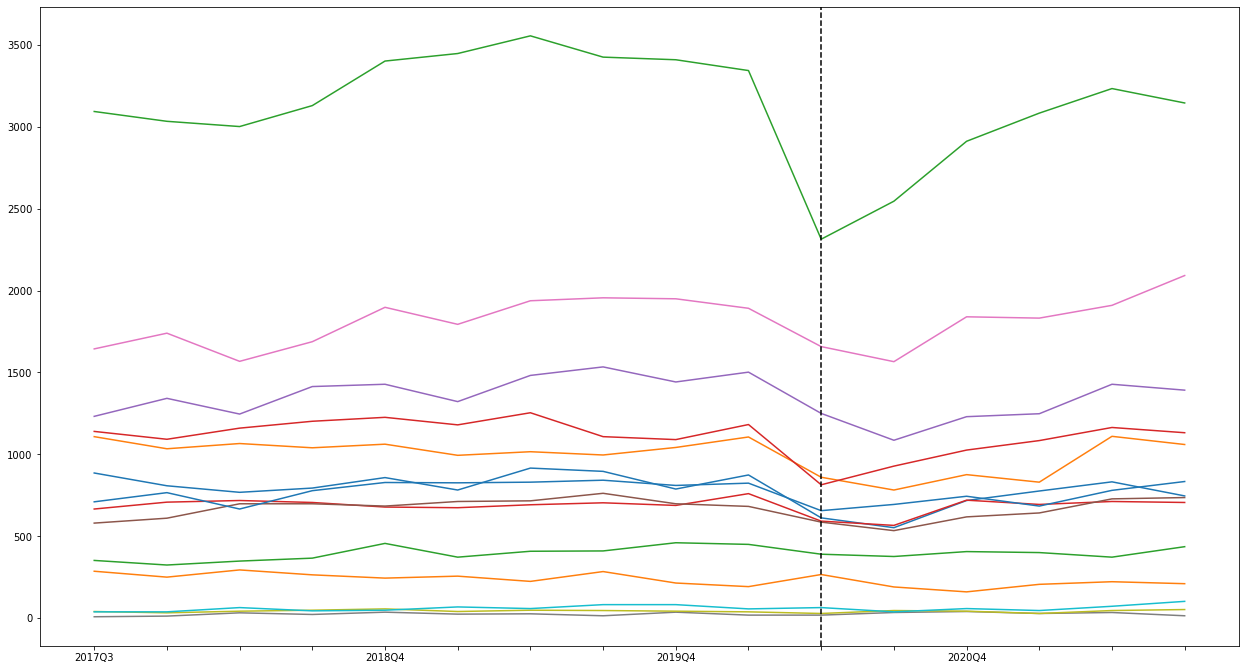

In [3]:
Reigons = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']

fig, d1 = plt.subplots(1, 1, sharey=True)

for i in Reigons:
    df = QuarterRemover(myData_31, i, 'All Cancer Types', '2017Q3', '2018Q3')
    newdf = df.to_numpy()
    x = newdf[:, 0]
    y = newdf[:, 1]
    d1.plot(x, y)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.axvline(x='2020Q2', color='k', linestyle='--')

fig.set_size_inches(18.5, 10.5, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

I next went on a little aside. Can we start to try and model things as a seasonal ARIMA process? Not quite sure how to implement this properly here as I keep getting a vast amount of errors. Perhaps my data set is too dimensionally reduced by this point?

   Quarter  NumberOfEligibleReferrals31DayStandard
22  2017Q3                                     886
23  2017Q4                                     808
24  2018Q1                                     768
25  2018Q2                                     794
27  2018Q4                                     858
28  2019Q1                                     782
29  2019Q2                                     916
30  2019Q3                                     896
31  2019Q4                                     788
32  2020Q1                                     874
33  2020Q2                                     612
34  2020Q3                                     552
35  2020Q4                                     718
36  2021Q1                                     776
37  2021Q2                                     832
38  2021Q3                                     746


<AxesSubplot:xlabel='Quarter'>

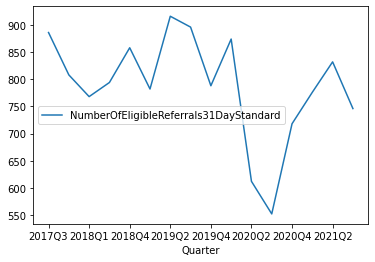

In [4]:
R15 = QuarterRemover(myData_31, 'S08000015', 'All Cancer Types', '2017Q3', '2018Q3')
print(R15)
R15.plot(x='Quarter', y='NumberOfEligibleReferrals31DayStandard')

#Code doesn't work properly.
#newR15 = R15.to_numpy()
#print(newR15[:, 1])
#my_order = (0, 0, 1)
#my_seasonal_order = (0, 0, 1, 2)
#model = sm.tsa.statespace.sarimax.SARIMAX(newR15[:, 1], order=my_order, seasonal_order=my_seasonal_order)

## Quantifying the Lasting Impact

Below I have started to think about how you quantify the impact.

1. Remove the year 2020Q2, 2020Q3 data.
2. Average over the remaining data.
3. Get the difference between the average and each of the removed data points.
4. Extrapolate to see how many quarters extra than the average it would take to recover.

[array([152.89256198347107], dtype=object), array([128.099173553719], dtype=object), array([196.69421487603307], dtype=object)]


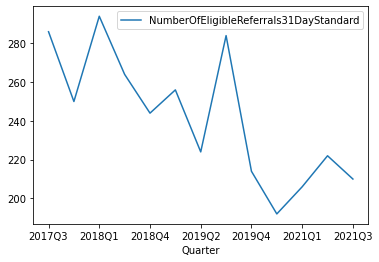

In [9]:
R = QuarterRemover(myData_31, 'S08000016', 'All Cancer Types', '2017Q3', '2018Q3')

R1 = R[R.Quarter != '2020Q2']
R2 = R1[R1.Quarter != '2020Q3']
R3 = R2[R2.Quarter != '2020Q4']
R3.plot(x='Quarter', y='NumberOfEligibleReferrals31DayStandard')

newR3 = R3.to_numpy()
av = sum(newR3[:, 1])/len(newR3[:, 1])

Q2 = R15[R15.Quarter == '2020Q2'].to_numpy()
Q3 = R15[R15.Quarter == '2020Q3'].to_numpy()
Q4 = R15[R15.Quarter == '2020Q4'].to_numpy()

dif2 = (abs(av - Q2[:, 1])/av) * 100
dif3 = (abs(av - Q3[:, 1])/av) * 100
dif4 = (abs(av - Q4[:, 1])/av) * 100

per = [dif2, dif3, dif4]
print(per)

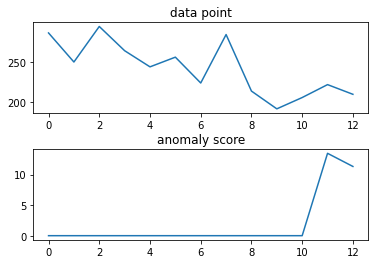

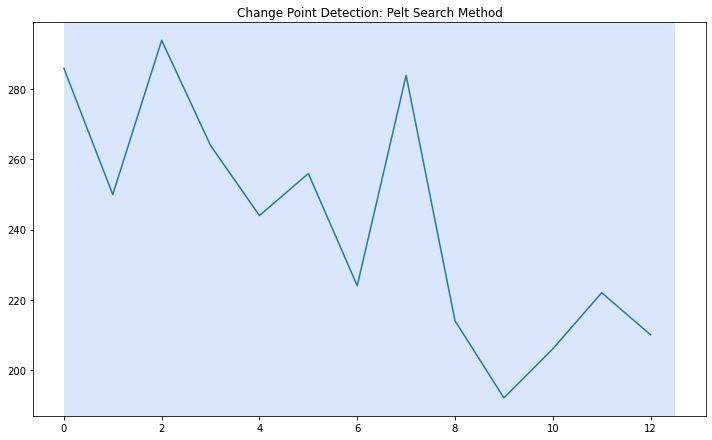

BadSegmentationParameters: 

In [13]:
import changefinder
import ruptures as rpt

points = newR3[:, 1]

f, (ax1, ax2) = plt.subplots(2, 1)
f.subplots_adjust(hspace=0.4)
ax1.plot(points)
ax1.set_title("data point")

#Initiate changefinder function
cf = changefinder.ChangeFinder()
scores = [cf.update(p) for p in points]
ax2.plot(scores)
ax2.set_title("anomaly score")
plt.show() 

#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
    
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=3)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()
    
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()
    
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

The above cannot run much of the changepoint detection since the data isn't rich.

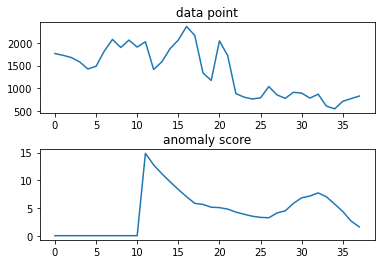

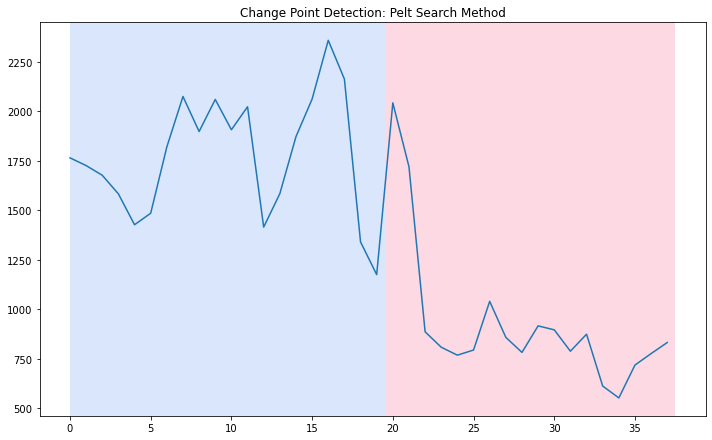

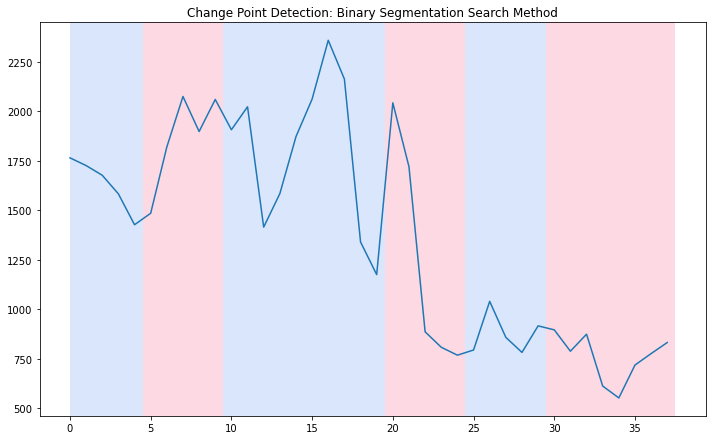

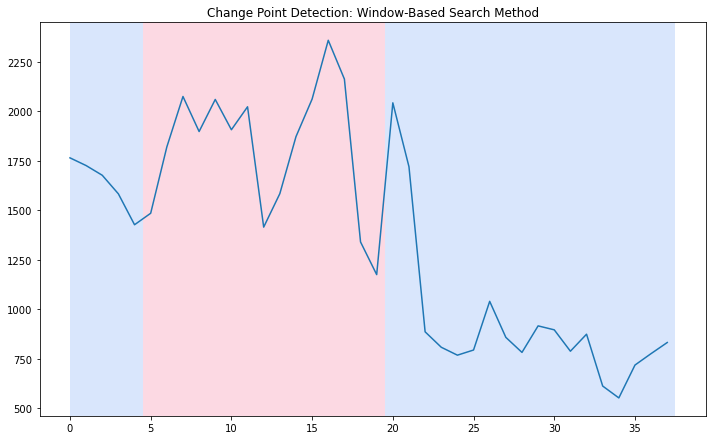

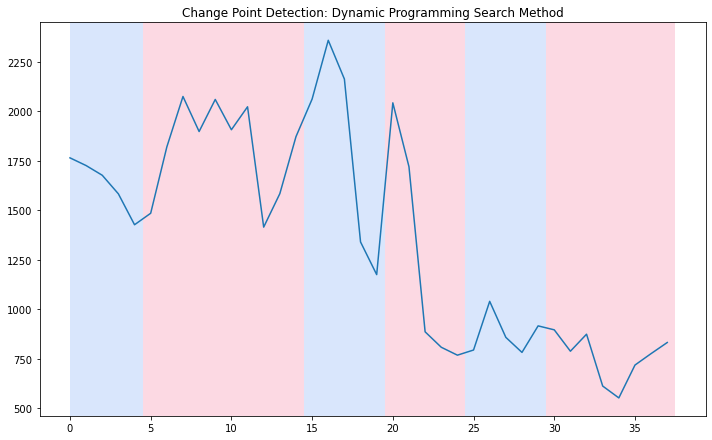

In [25]:
x, y, a, b = ReigonTypeQuarterSelector(myData_31, 'S08000015', 'All Cancer Types', '2021Q3')
points = y.to_numpy()

#CHANGEFINDER PACKAGE
f, (ax1, ax2) = plt.subplots(2, 1)
f.subplots_adjust(hspace=0.4)
ax1.plot(points)
ax1.set_title("data point")
#Initiate changefinder function
cf = changefinder.ChangeFinder()
scores = [cf.update(p) for p in points]
ax2.plot(scores)
ax2.set_title("anomaly score")
plt.show() 

#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=5)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
    
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=5)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()
    
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=10, model=model).fit(points)
my_bkps = algo.predict(n_bkps=5)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()
    
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=5)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()